<a href="https://colab.research.google.com/github/XTMay/AI_OCR/blob/main/layoutlmv3_ner/Lec_9_LayoutLMv3_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LayoutLMv3 架构与工作原理

## 课程目标

	•	理解 LayoutLM 系列的发展背景与应用场景
	•	掌握 LayoutLMv3 的核心架构设计
	•	理解其文本与图像的联合建模方式
	•	学会其三大预训练目标（MLM / MIM / WPA）
	•	了解其在不同任务上的表现和优势

## 1. 背景与应用场景

### 1.1 什么是 Document AI？

Document AI 是针对文档（如 PDF、扫描件、票据、表单等）进行自动化理解、信息抽取和分析的技术。
它涉及：

	•	文本识别（OCR）
	•	版面分析（Layout Analysis）
	•	表格/表单理解（Form Understanding）
	•	文档分类
	•	文档问答（DocVQA）

现实应用：

	•	发票自动入账
	•	法律合同关键信息提取
	•	学术论文版面结构分析

### 1.2 LayoutLM 系列发展

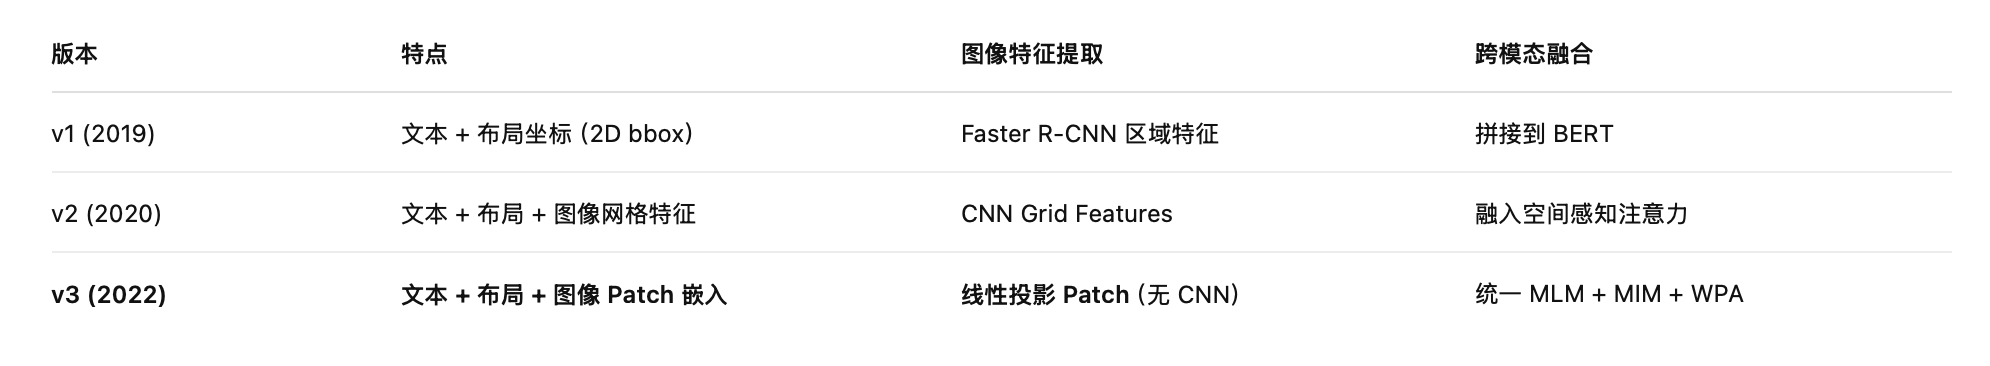

*v3 最大创新：去掉 CNN / Faster R-CNN，直接用 patch embedding，简化模型并提升跨模态一致性。*

LayoutLMv3 通过使用 patch embedding（类似 ViT 的方法）取代 CNN 主干网络，简化了 LayoutLMv2 的架构，并在三个目标上进行预训练：掩码语言建模（MLM）、掩码图像建模（MIM） 和 词-图像块对齐（WPA）。

### LayoutLM

在 LayoutLM 中，作者在词语的有意义的词嵌入（word embeddings）基础上，额外加入了词语在页面上的 位置坐标（x-y 坐标） 作为位置嵌入（positional embeddings）。
除了这些坐标位置嵌入之外，模型还接收了词语的图像特征，期望能够嵌入文字的各种视觉信息，比如 加粗（boldness）、斜体（italics） 等。

这些图像特征是通过 Faster R-CNN 模型提取的。不过需要注意的是，在预训练阶段，模型并不会接触到 Faster R-CNN 提取的图像特征；只有在微调阶段，我们才会将 Faster R-CNN 最后一层提取到的图像特征输入给模型。
后面我们会看到，这种设计会带来一些问题。

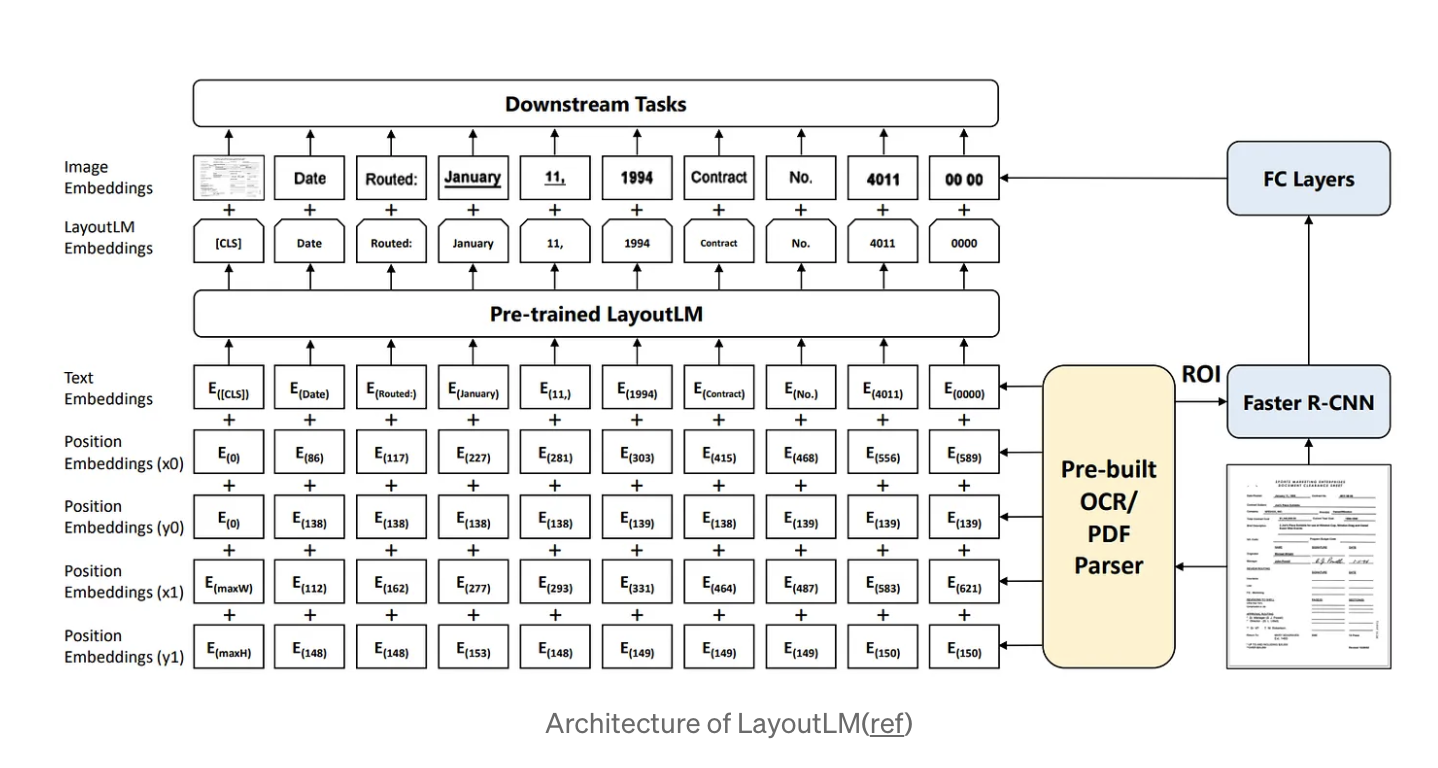

### LayoutLM 架构图 的工作原理，从下到上分层说明。

#### 1. 输入阶段

**(a) 文本输入**

	•	Text Embeddings：由预训练的 BERT（或 RoBERTa）生成的词嵌入，每个 token 都有一个向量表示，比如 [CLS]、Date、January 等。
	•	Position Embeddings (x0, y0, x1, y1)：

这是文档中每个词的 二维布局位置，来自 OCR 或 PDF 解析器：

	•	x0, y0：左上角坐标
	•	x1, y1：右下角坐标
	•	这些坐标经过离散化（quantization）和归一化后映射为嵌入向量。
	•	最终的词位置表示：

文本嵌入 + 四组位置嵌入相加，得到既包含语义又包含空间位置信息的 token 表示。


**(b) 图像输入**

	•	输入文档先经过 Pre-built OCR/PDF Parser 识别文本位置（用于位置嵌入）并生成 ROI（Region of Interest）。
	•	Faster R-CNN（目标检测网络）提取对应文本区域的视觉特征，例如字体粗细、倾斜度等。
	•	这些图像特征只在 微调阶段 使用，不参与预训练阶段的 MLM。


#### 2. 融合阶段

	•	Pre-trained LayoutLM 模块：
	•	核心是一个多层 Transformer，输入是：
	•	文本+位置嵌入（预训练阶段主要使用这个）
	•	微调时可以额外加上图像嵌入（来自 Faster R-CNN）。
	•	这样，模型既知道词的语义，又知道它在文档上的位置，还可以感知视觉风格。


#### 3. 下游任务阶段

	•	LayoutLM Embeddings + Image Embeddings 被送入下游任务模块。
	•	下游任务可以是：
	•	表单理解（Form Understanding）
	•	收据理解（Receipt Understanding）
	•	文档问答（DocVQA）
	•	文档分类
	•	最后的 FC Layers（全连接层） 负责将 Transformer 输出映射到任务目标（分类、抽取等）。

#### 4. 关键点总结

	1.	多模态输入：结合文本、版面布局坐标、图像特征。
	2.	位置嵌入的创新：用 (x0, y0, x1, y1) 明确 token 在页面上的矩形范围。
	3.	图像特征延迟使用：Faster R-CNN 的输出不参与预训练，只在微调时加入，这会造成图像模态与文本模态在预训练中未充分对齐（LayoutLMv2/v3 改进了这一点）。
	4.	主要预训练任务：MLM（Masked Language Modeling）。


## LayoutLMv2

LayoutLM 模型的一个缺点是：某一类文档的领域知识不容易迁移到另一类文档中，因此一旦文档类型发生变化，这些模型通常需要重新训练。
主要原因是，它使用了 BERT 的输出嵌入，而 Faster R-CNN 的图像特征是在最后阶段才加入的，也就是说，Transformer（BERT）的预训练任务实际上并没有“看到”图像特征，这会导致在**新文档格式上的泛化能力不足。**

为了解决这个问题，**LayoutLMv2 提出了一种 多模态方法**：
在预训练任务中，同时嵌入文本、图像和版面布局特征，这样在 Transformer 预训练阶段，模型就能同时学习文本特征、图像特征以及文档的布局信息。

在 LayoutLMv2 中：

	•	视觉嵌入 由 ResNeXt-FPN 提取，并且在预训练过程中，模型的权重会通过反向传播更新。
	•	布局嵌入 除了包含 x-y 坐标，还额外输入了图像片段的 宽度和高度。
	•	输入文档会像文本 token 一样部分掩码：当文档中的某个单词 token 被替换为 [MASK] 时，文档图像中对应的那部分区域也会被涂黑（redacted）。

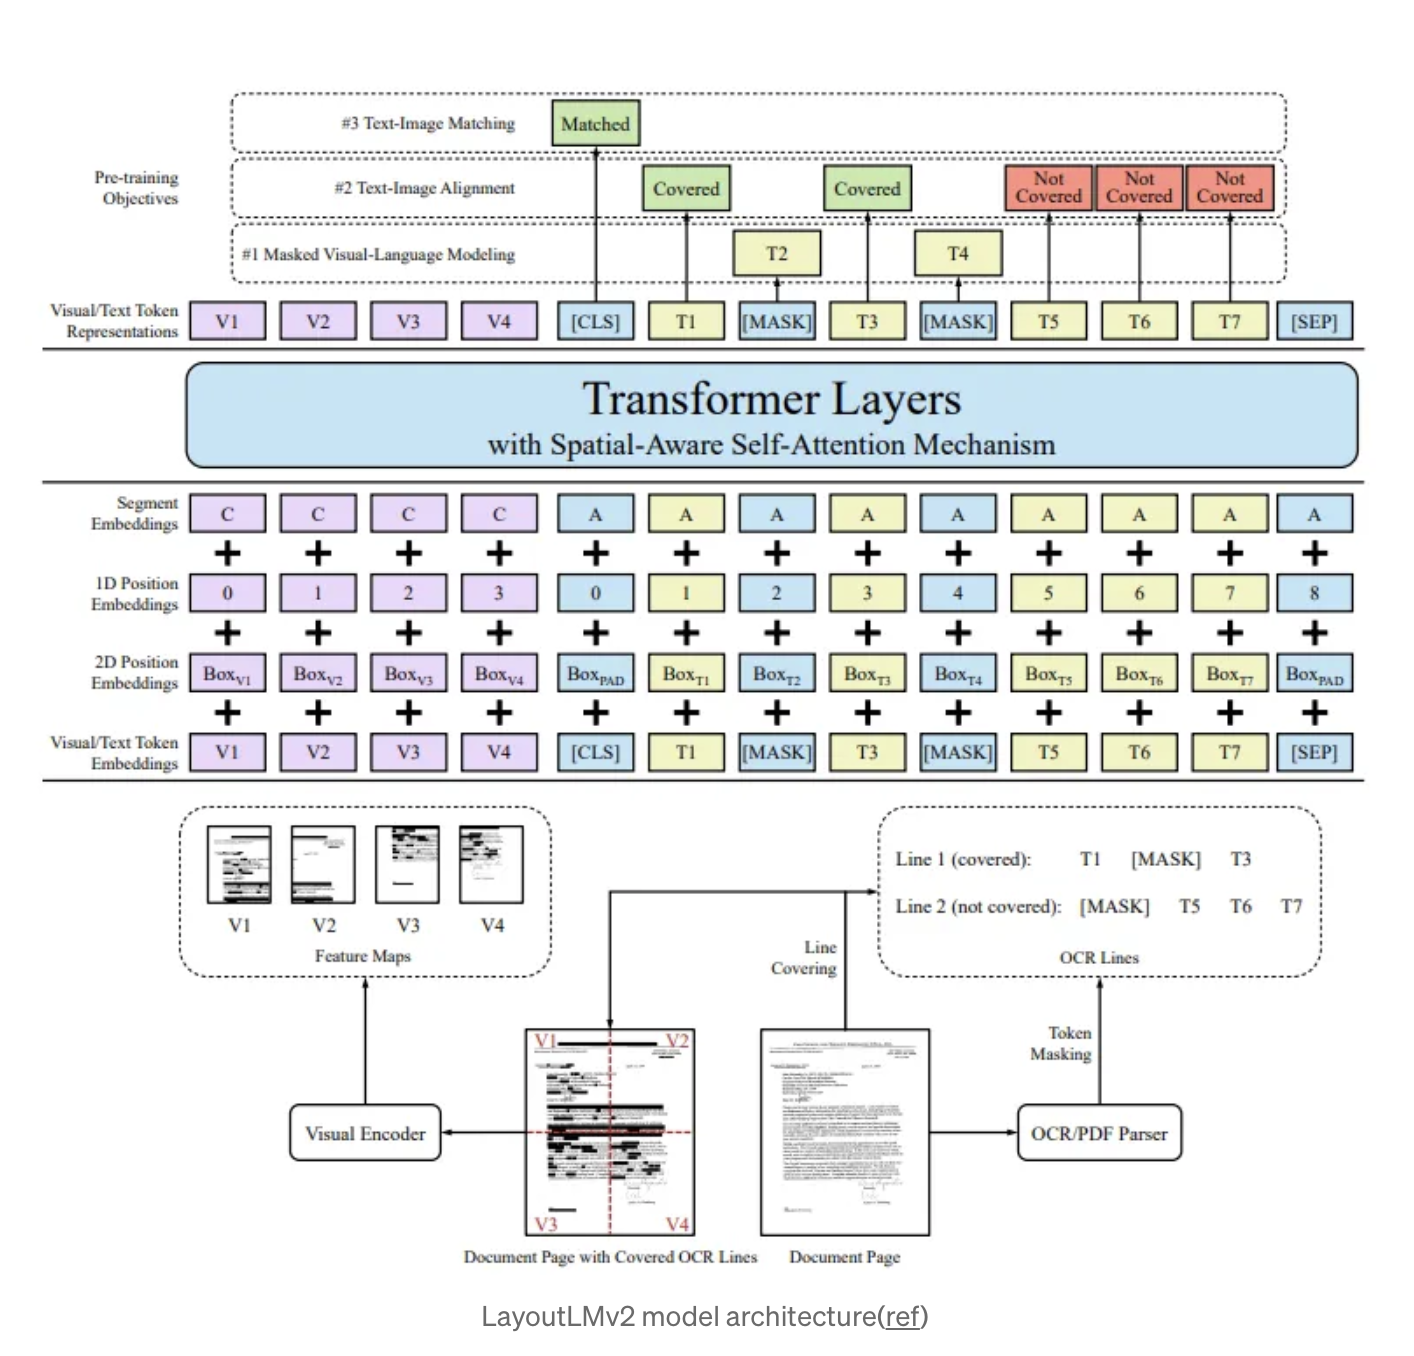

### 1. 输入与特征提取

**三种模态输入**

* **文本（Text Tokens）**：来自 OCR（或 PDF 解析器）的单词序列，比如 `T1, T2, …`
* **图像（Visual Tokens）**：用 ResNeXt-FPN 从整页文档图像中提取的 **Feature Maps**（V1, V2, …）
* **布局（Layout/Spatial Tokens）**：OCR token 在页面中的二维位置（x₁, y₁, x₂, y₂）+ 宽度与高度

**视觉部分的改进**

* 原 LayoutLM 是先用 BERT 编码文本，再在最后阶段融合图像特征 → 图像信息没参与预训练的语言建模
* LayoutLMv2 直接在 Transformer 输入阶段，把视觉特征和文本特征“并列”输入，使它们在 **自注意力机制** 中交互

### 2. 嵌入层（Embedding Layer）

每个 token（无论是文本还是视觉 patch）都由以下信息叠加得到：

1. **Visual/Text Token Embeddings**：文本 token 的词向量或视觉 patch 的特征向量
2. **2D 位置嵌入（2D Position Embeddings）**：token 在页面上的 (x₁, y₁, x₂, y₂) 坐标
3. **1D 位置嵌入（1D Position Embeddings）**：在 token 序列中的顺序位置（BERT 的位置编码）
4. **Segment Embeddings**：区分文本段落（A/B）与视觉 patch（C）
5. 所有嵌入向量通过 **加法** 融合，形成最终的输入 token 表示

### 3. Transformer 与预训练任务

**Transformer Layers**

* 核心是 **Spatial-Aware Self-Attention**，在注意力计算中同时考虑文本与视觉 token 以及它们的空间位置
* 文本、视觉、布局三种模态信息在多头注意力机制中交互学习

**三个预训练任务**（图上方绿色、黄色、红色的标注）：

1. **Masked Visual-Language Modeling (MVLM)**

   * 类似 BERT 的 MLM
   * 当文本 token 被 mask 时，图像对应的区域也会被涂黑（redacted）
   * 模型需结合剩余文本、视觉信息、版面位置推断被 mask 的词

2. **Text-Image Alignment (TIA)**

   * 判断给定文本 token 与图像区域是否对齐（Covered / Not Covered）
   * 学习文字与视觉的对齐关系

3. **Text-Image Matching (TIM)**

   * 判断一个页面的文本和图像是否属于同一份文档（Matched / Not Matched）
   * 增强模型在跨模态一致性上的判别能力

**总结**
相比原 LayoutLM，LayoutLMv2 的关键改进是**三模态联合预训练**：

* 视觉特征在 Transformer 输入阶段就参与计算，而不是最后拼接
* 使用空间感知的自注意力，让模型在语义理解中自然考虑版面布局
* 在预训练中通过 MVLM、TIA、TIM 同时强化文本、图像、布局之间的联系
  → 因此在不同文档格式、不同领域上的泛化能力显著提升

## 2. LayoutLMv3 架构总览

### **LayoutLMv3 – 核心特性**

#### **1. 不再依赖预训练 CNN 主干网络**

* 不同于 LayoutLMv1/v2 使用 **Faster R-CNN**（v1）或 **ResNeXt-FPN**（v2）提取视觉特征，LayoutLMv3：

  * **不依赖**独立的视觉特征提取器。
  * 直接将原始文档图像切分为 **图像 patch**（类似 ViT 方法）作为输入。
  * 无需区域标注（Region Annotation）。
  * **优势**：参数更少、结构更简洁、可端到端训练。

#### **2. 统一的多模态预训练**

* 在 Transformer 中直接联合处理 **文本 token** 和 **图像 patch**。
* 两个主要的自监督目标：

  * **MLM（Masked Language Modeling）**：预测被 `[MASK]` 的文本 token。
  * **MIM（Masked Image Modeling）**：预测被 mask 的图像 patch。
* MLM + MIM 同时优化，有助于学习一个 **统一的跨模态语义空间**。

#### **3. 词–图像块对齐（Word-Patch Alignment, WPA）**

* 问题：MLM/MIM 的随机 mask 操作，模型并不知道文本 token 与图像 patch 之间的对应关系。
* 解决方法：

  * 当未被 mask 的文本 token 对应的图像 patch 也未被 mask → 标记为 **对齐（Aligned）**。
  * 否则 → 标记为 **未对齐（Unaligned）**。
  * 将文本与图像的上下文向量拼接后输入 **两层 MLP**，预测对齐/未对齐（二分类，二元交叉熵损失）。
  * **效果**：显著提升跨模态对齐能力与一致性。

#### **4. 面向通用文档 AI**

* 同时适用于 **文本驱动**（OCR 为主）和 **图像驱动**（版面/图形为主）的文档任务。
* 可无缝迁移到：

  * 表单理解（Form Understanding）
  * 文档分类（Document Classification）
  * 视觉问答（Visual Question Answering）
  * 关键信息抽取（Key-Value Extraction）
  * 收据/身份证/发票解析
  * 多页复杂文档处理

#### **与 LayoutLMv2 的核心差异**

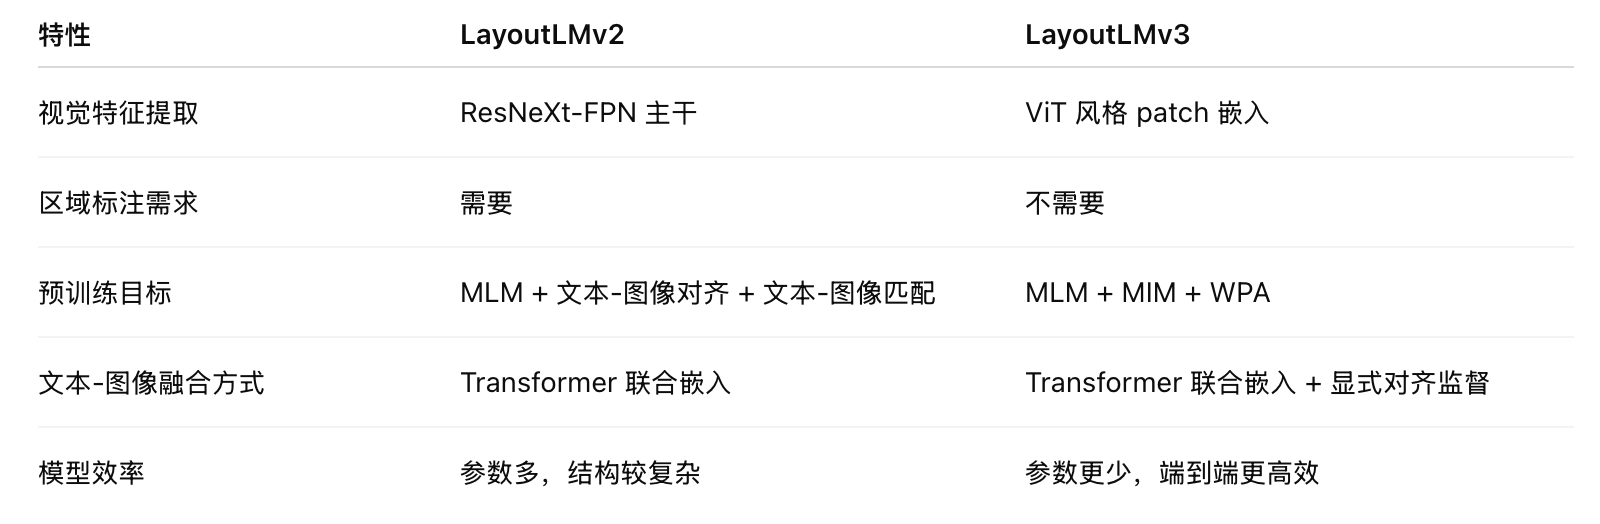

**总结**
LayoutLMv3 移除了外部视觉主干网络，引入统一的 MLM+MIM 预训练目标，并通过 WPA 显式建模跨模态对齐，结构更简洁、泛化能力更强，适用范围更广。

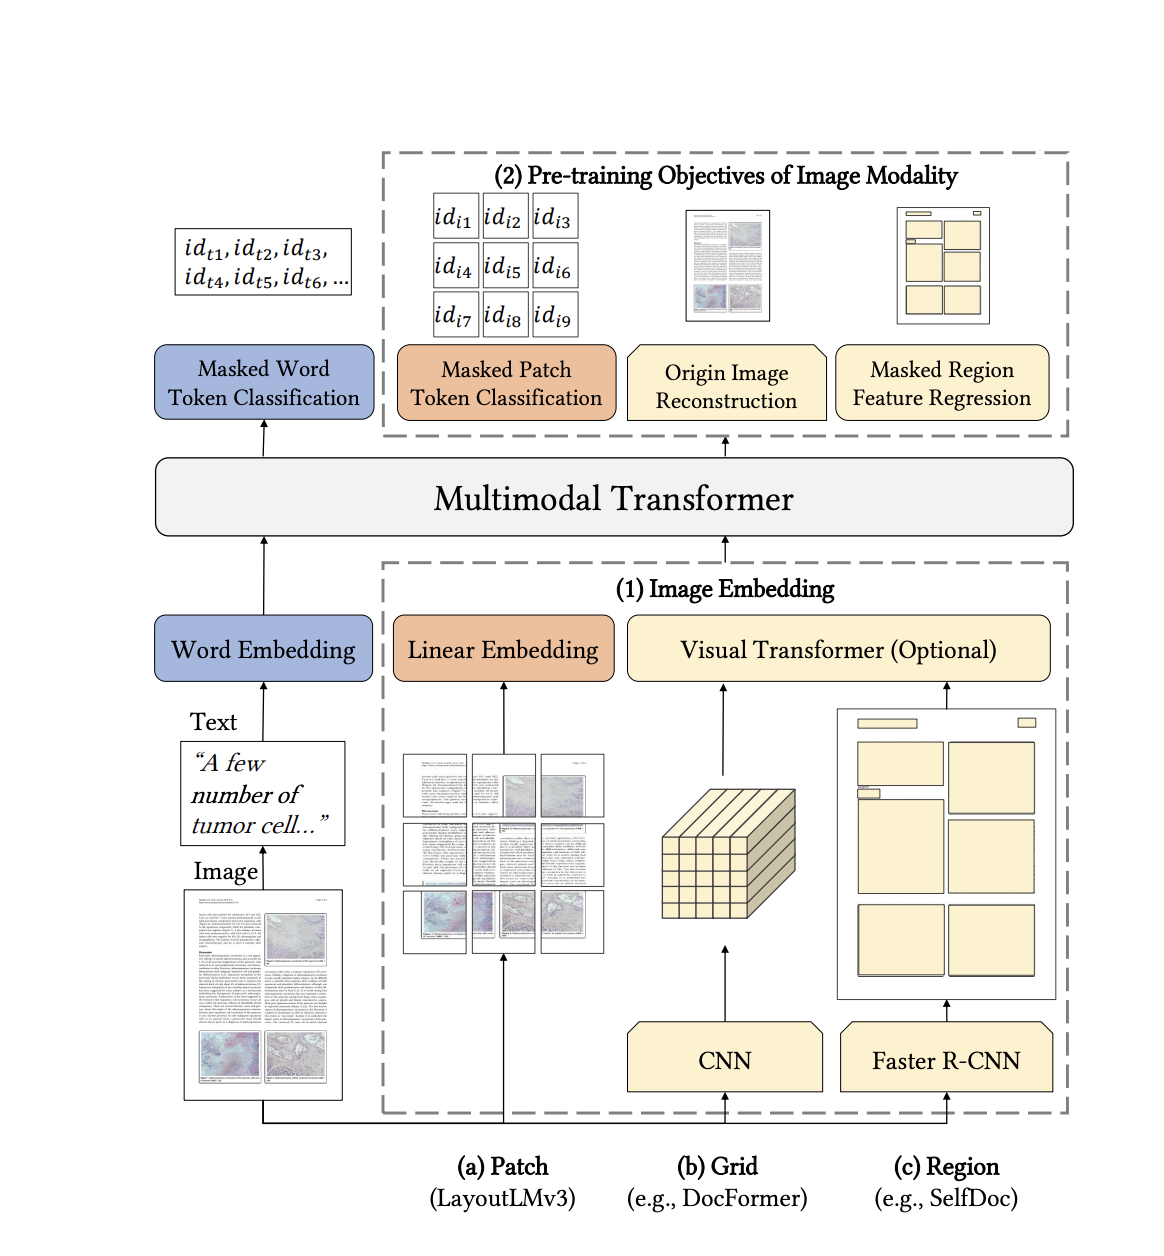

相比 v1/v2，它的最大变化是**完全取消了 CNN / Faster R-CNN 等外部视觉特征提取器**，改为将图像直接切成 patch 送入 Transformer，与文本 token 一起做**统一的多模态建模**。

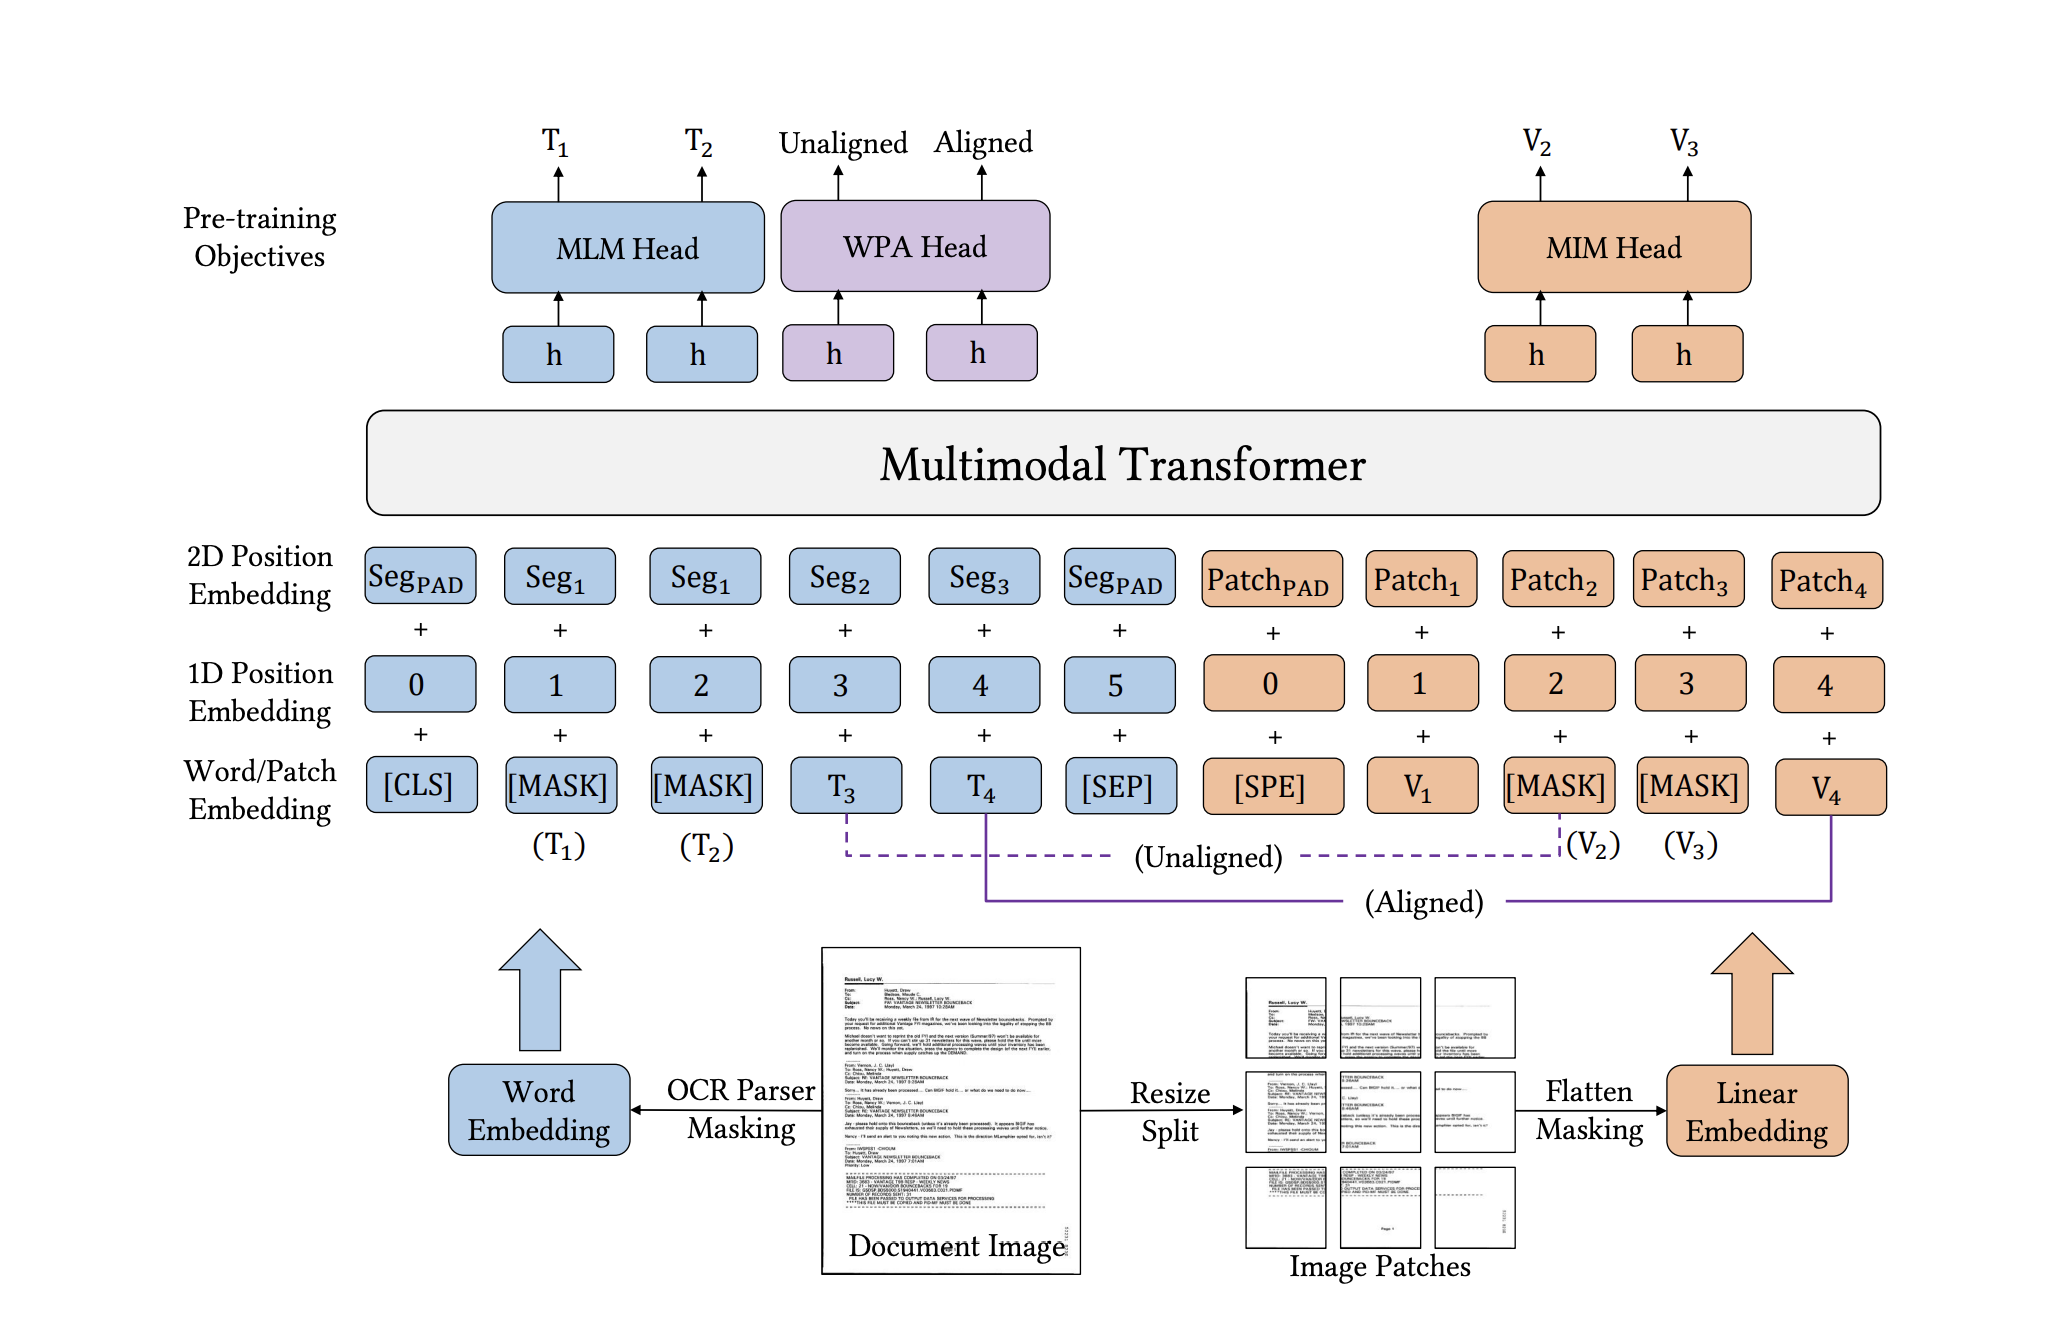

### 2.1 输入模块

(1) 文本嵌入

	•	词嵌入：来自预训练 RoBERTa
	•	1D 位置嵌入：表示 token 在序列中的顺序
	•	2D 布局位置嵌入：表示 bounding box（x, y, w, h），归一化到 [0, 1000] 区间
	•	Segment-Level 坐标：同一文本段落共享坐标（减少噪声）

(2) 图像嵌入

	•	将文档图像缩放到固定大小（如 224×224）
	•	切分成 P×P patch（默认 16×16）
	•	线性投影到 D 维向量（无 CNN）
	•	加入可训练的 1D 位置编码

### 2.2 多模态 Transformer
	•	结构：多层多头自注意力 + 前馈网络
	•	输入序列 = [文本tokens] + [图像patch tokens]
	•	注意力机制可在不同模态间自由交互

## 3. 预训练任务

LayoutLMv3 有三个自监督任务 ￼：

### 3.1 Masked Language Modeling (MLM)
	•	目标：预测被掩码的文本 token
	•	掩码比例：约 30%，采用 span masking（Poisson 分布 λ=3）
	•	损失函数：交叉熵


### 3.2 Masked Image Modeling (MIM)
	•	目标：预测被掩码的图像 patch token
	•	掩码比例：约 40%，采用 blockwise masking
	•	图像 token 由 离散 VAE (dVAE) 提取（类似 BEiT）
	•	强调捕捉高层布局结构而非像素细节

### 3.3 Word-Patch Alignment (WPA)
	•	目标：判断一个文本 token 对应的图像 patch 是否被掩码
	•	二分类任务：Aligned / Unaligned
	•	用两层 MLP 实现
	•	作用：加强精细跨模态对齐

在 LayoutLMv3 里，图像 patch 指的是把一整张文档图像按照固定大小切成很多小块，然后每个小块（patch）被当作一个“图像单词”来处理，送进 Transformer。

#### 为什么要用 patch？

	•	类似文本中的 token（单词），我们把图像分割成小的方块 patch，这样 Transformer 就可以一次性处理“图像词”序列。
	•	避免直接用整张图像（像素量太大，计算成本爆炸）。
	•	ViT（Vision Transformer） 就是用这种方式替代 CNN 来提取图像特征的。

#### Patch 是怎么切的？

假设文档图像被缩放到 224×224 像素，每个 patch 是 16×16 像素：

224 / 16 = 14  
14 × 14 = 196 个 patch

也就是说，这张图会被切成 196 个小方块。

#### Patch 如何变成向量？

	1.	切分：把图像分成很多 patch。
	2.	展平：把每个 patch 的像素展平成一个向量（长度 = patch面积 × 通道数）。
	3.	线性投影：用一个可训练的矩阵把这个向量映射到固定维度（比如 768 维）。
	4.	位置编码：加上 patch 在整张图像中的位置（顺序），保证 Transformer 知道它在图像哪里。


#### 在 LayoutLMv3 中的作用

	•	这些图像 patch token 会和 文本 token 一起拼接输入到多模态 Transformer。
	•	这样，模型可以同时“看到”文字和文档的视觉布局信息。

#### 形象比喻：
想象你在看一张报纸，但你把报纸裁成很多小方块（patch），然后按顺序把这些小方块交给模型看。模型会像阅读单词一样，逐个理解每个小方块里的信息，并结合位置信息重建对整篇文档的理解。

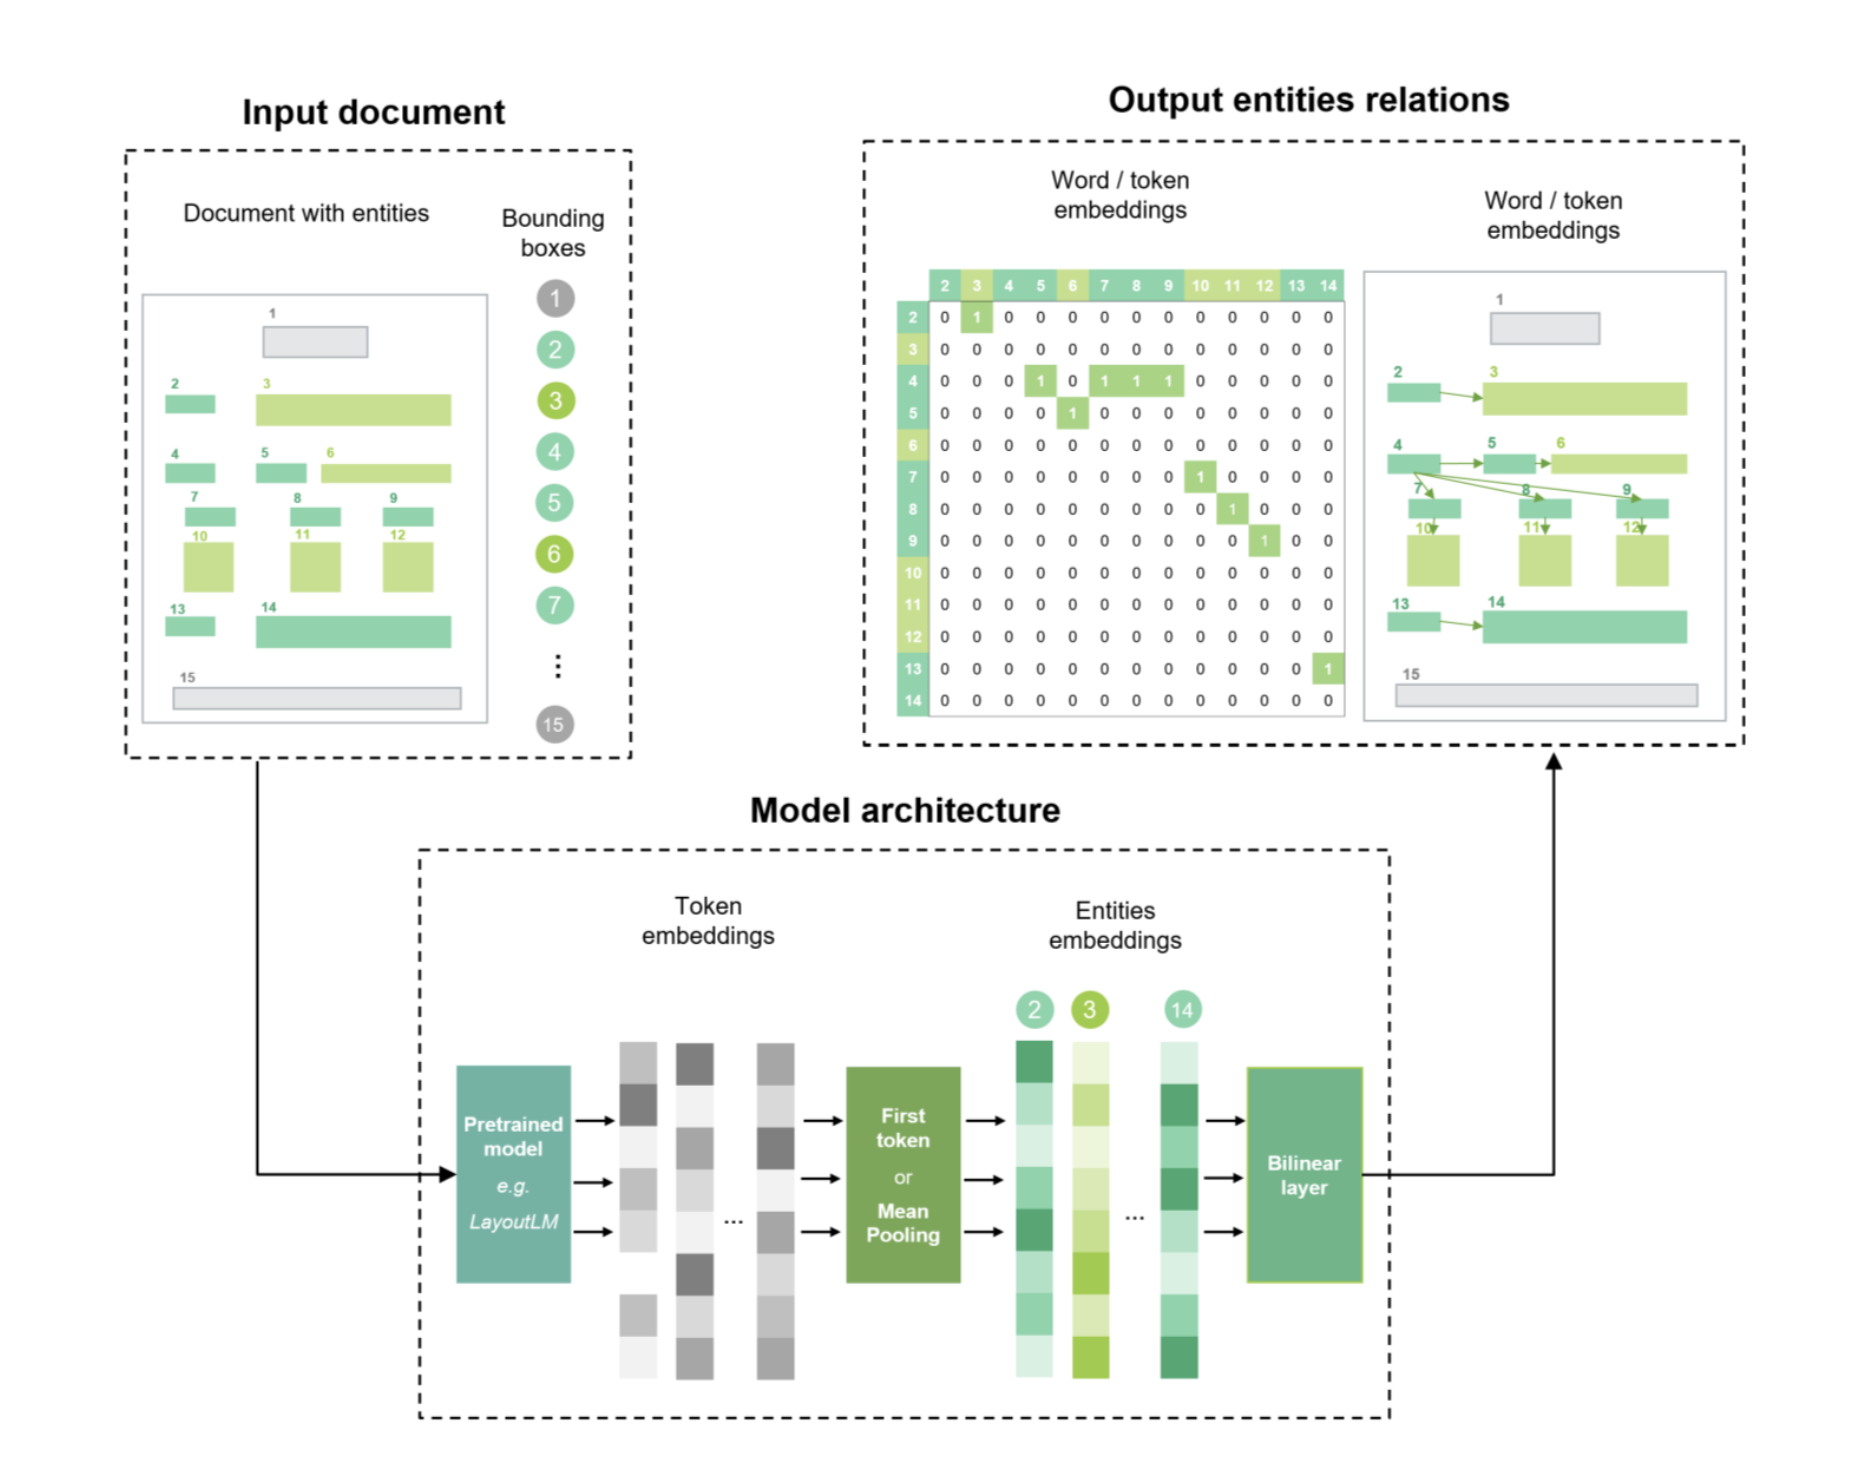

## 4. 工作流程示意

```flowchart TD

    A[文档图像 + OCR提取文本+坐标] --> B1[文本嵌入: 词 + 1D位置 + 2D布局]
    A --> B2[图像嵌入: Patch切分 + 线性投影 + 1D位置]
    B1 & B2 --> C[拼接输入 Transformer]
    C --> D[多层多模态自注意力]
    D --> E1[MLM: 预测文本token]
    D --> E2[MIM: 预测图像patch token]
    D --> E3[WPA: 对齐判断]
    D --> F[输出跨模态表示]
```

## 5. 实验结果与优势

### 5.1 数据集与任务

	•	文本中心任务：FUNSD（表单理解）、CORD（收据理解）、DocVQA（文档问答）
	•	图像中心任务：RVL-CDIP（文档分类）、PubLayNet（版面分析）

### 5.2 结果亮点

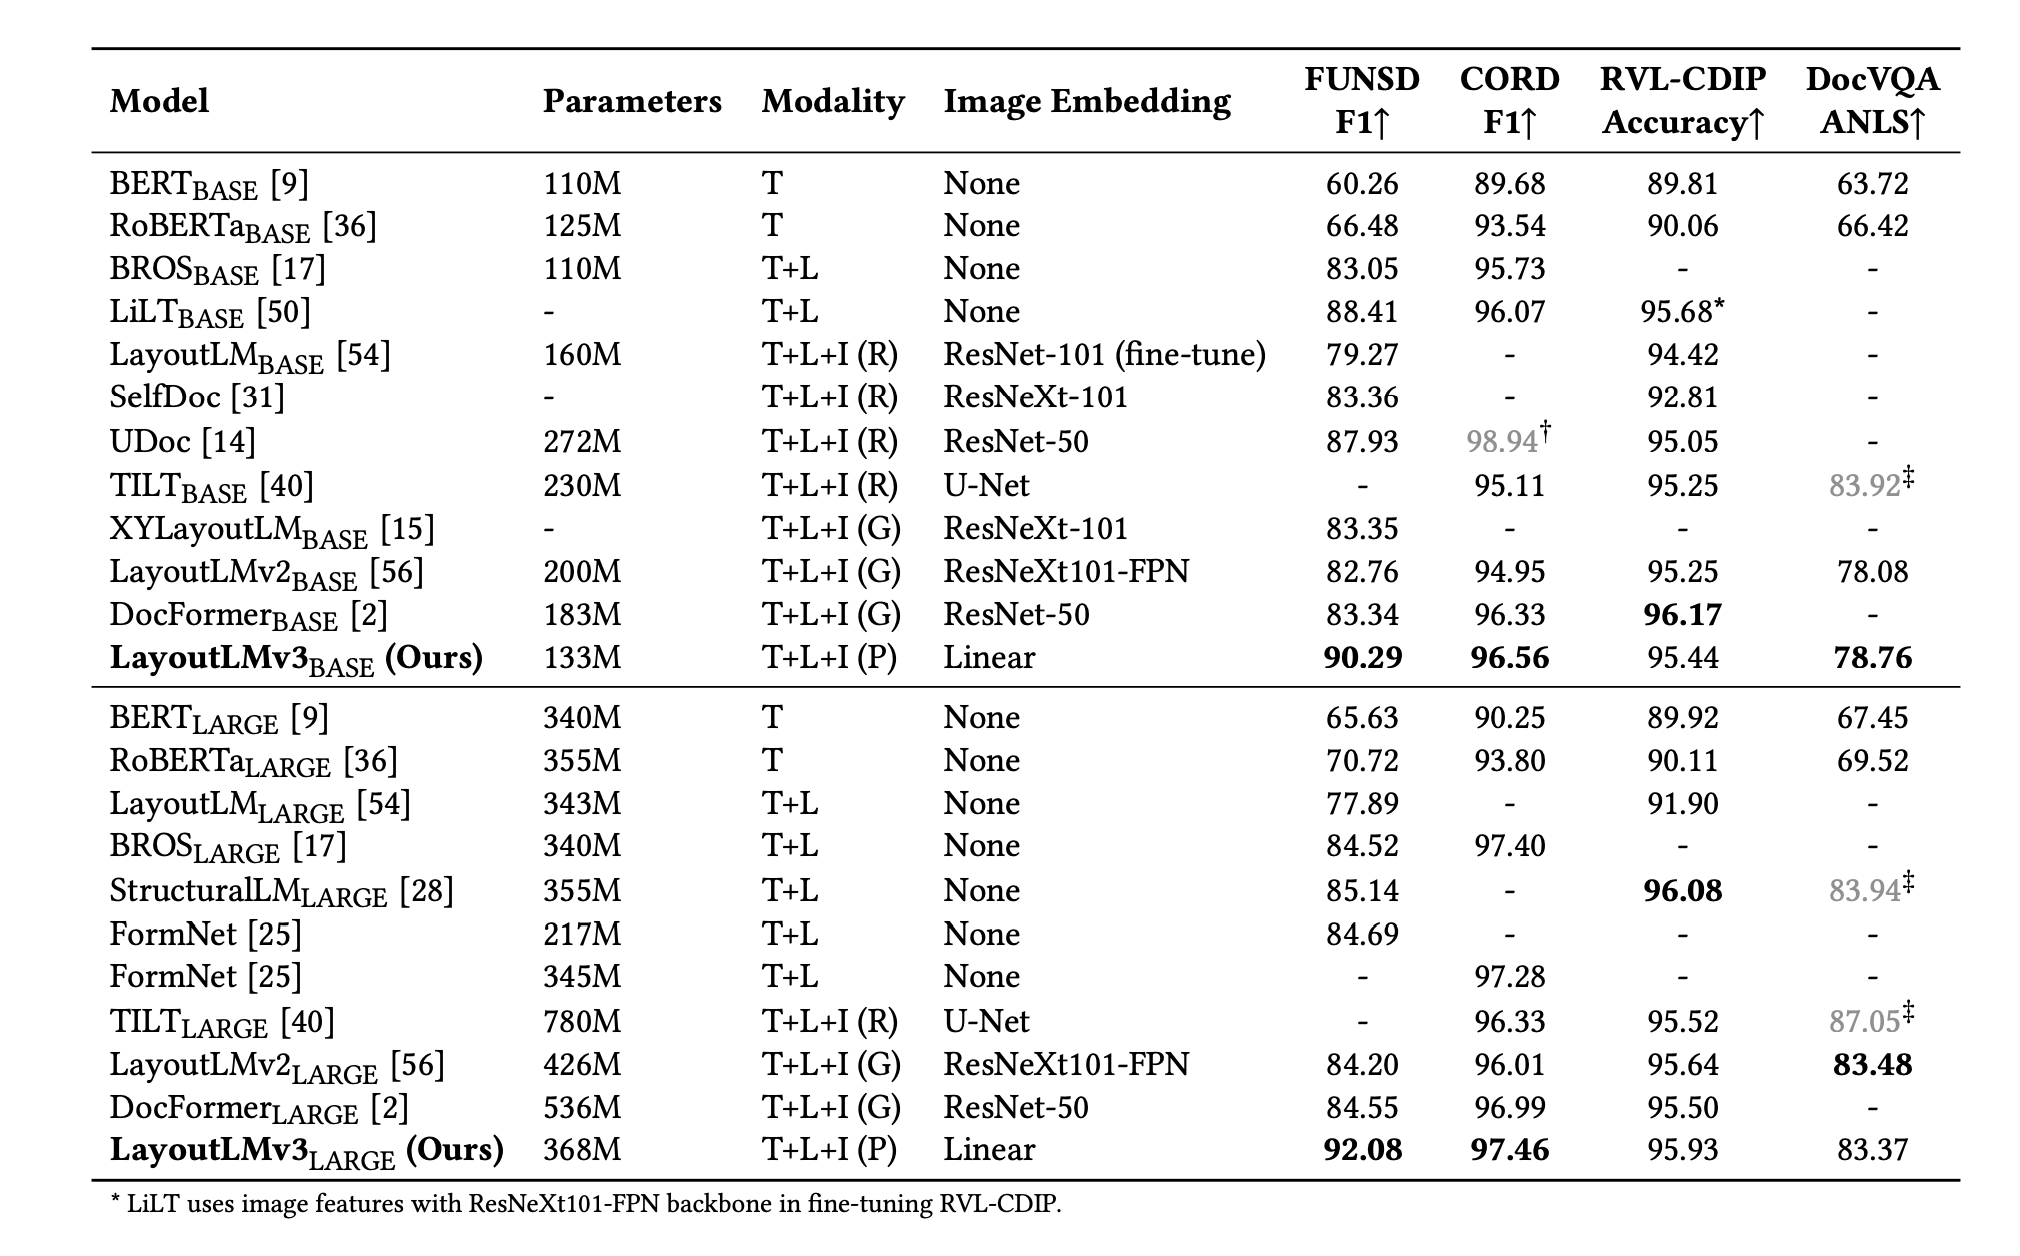

	•	参数更少，性能更好
	•	跨任务表现强：文本、图像任务均 SOTA

## 6. Ablation Study（消融实验）

	•	仅文本 (MLM)：无法处理纯视觉任务
	•	加线性图像嵌入但无 MIM：训练不收敛
	•	加 MIM：视觉任务收敛且性能提升
	•	加 WPA：进一步提升所有任务表现

## 7. 总结

LayoutLMv3 的创新：

	1.	去 CNN：直接用 patch embedding
	2.	统一掩码任务：MLM + MIM
	3.	细粒度对齐：WPA
	4.	多任务适应性强：文本中心、图像中心都表现优异

## 8. 参考文献
	1.	Huang, Y., Lv, T., Cui, L., Lu, Y., & Wei, F. (2022). LayoutLMv3: Pre-training for Document AI with Unified Text and Image Masking. Proceedings of the 30th ACM International Conference on Multimedia (MM ’22). https://doi.org/10.1145/3503161.3548112  ￼
	2.	Hugging Face. (n.d.). LayoutLMv3 Model Documentation. https://huggingface.co/docs/transformers/en/model_doc/layoutlmv3
	3.	Shivarama, S. (2023). LayoutLMv3: From Zero to Hero - Part 1. Medium. https://medium.com/@shivarama/layoutlmv3-from-zero-to-hero-part-1-85d05818eec4
	4.	Dair AI. (2023). Papers Explained #13: LayoutLMv3. Medium. https://medium.com/dair-ai/papers-explained-13-layout-lm-v3-3b54910173aa
	5.	ML Expert. (2023). Document Classification with LayoutLMv3. https://www.mlexpert.io/blog/document-classification-with-layoutlmv3


## LayoutLMv3 如何学 BIO 标签

###  BIO 标签的含义

实体-非实体：

* **B-XXX**：实体的第一个 token（Begin）
* **I-XXX**：实体中除第一个以外的 token（Inside）
* **O**：不属于任何实体（Outside）

### （1）输入阶段

* 模型接收 OCR 提取的 token（带位置坐标）+ 文档图片 patch。
* 文本经过 **词嵌入**（word embedding），位置经过 **布局嵌入**（layout embedding），图片经过 **视觉 patch embedding**，然后融合输入到 Transformer。

### （2）特征表示

* Transformer 输出每个 token 的隐藏向量 **hᵢ**，它融合了：

  * 文本语义（MLM 预训练学到）
  * 版面布局（位置 embedding 学到）
  * 视觉特征（MIM/WPA 预训练学到）

### （3）BIO 分类层

* 在微调阶段，给每个 token 的向量 **hᵢ** 接一个全连接层（FCNN）映射到 **标签空间**：

$$
z_i = W h_i + b
$$

* 然后用 **Softmax** 得到每个标签的概率分布：

$$
\hat{y}_i = \text{Softmax}(z_i)
$$

### （4）训练过程

* 使用人工标注的 BIO 标签数据集（如 FUNSD、SROIE）。
* 损失函数是 **交叉熵损失（Cross-Entropy Loss）**：

$$
\mathcal{loss} = -\sum_{i} \sum_{c} y_{i,c} \log \hat{y}_{i,c}
$$

* $y_{i,c}$：token i 在类别 c 上的真实标签（one-hot）

* $\hat{y}_{i,c}$：模型预测的概率

* 通过 **反向传播（Backpropagation）**，同时更新 Transformer 主体和 BIO 分类层参数。

### 为什么预训练很重要

* BIO 标签任务只在微调阶段才出现，但 LayoutLMv3 在预训练时已经学会了：

  * 文本模式（MLM）
  * 文本-视觉对齐（WPA）
  * 文本-布局对齐（位置编码）
* 所以微调时，BIO 分类头只需利用已有的多模态表示，就能快速学到**实体边界和类别**。

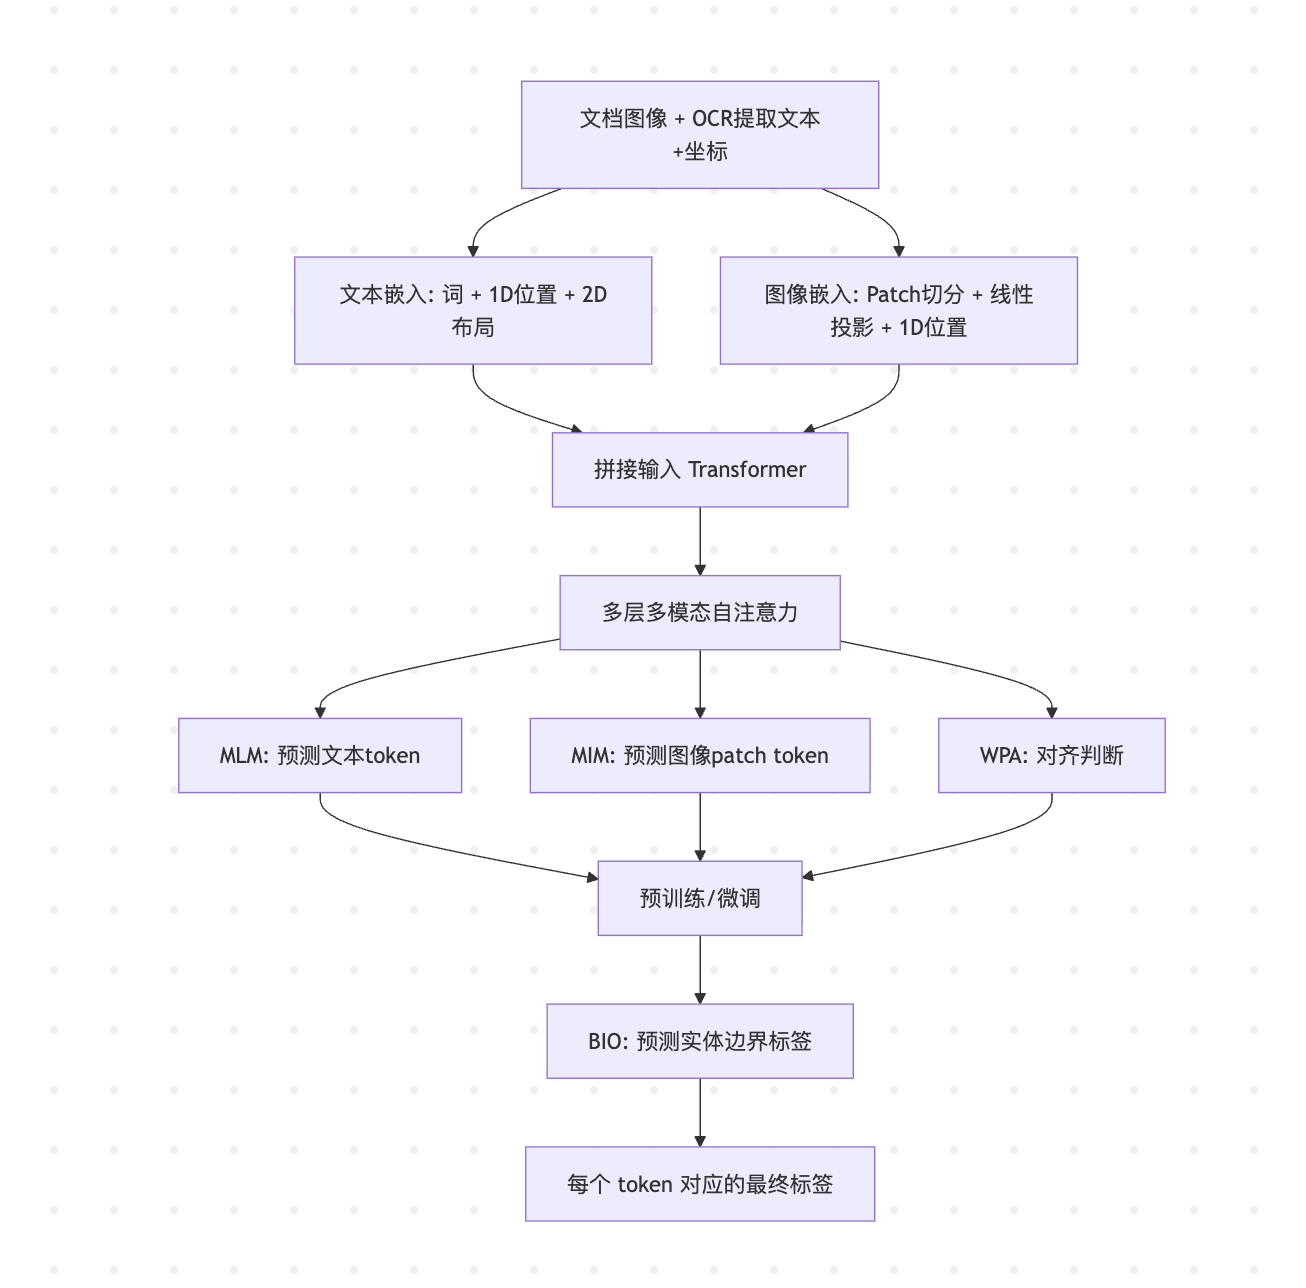

### 输入

LayoutLMv3 是一个 **多模态模型**，输入通常包括：

1. **文本序列（tokens）**

   * 来自 OCR 的文本，比如发票上的 “Invoice No: 12345”。
2. **文本位置/布局信息**

   * 每个 token 的 2D 坐标 `(x0, y0, x1, y1)`。
3. **图像信息（可选）**

   * 整张发票图像，模型通过视觉 encoder 得到 patch embedding。
4. **BIO 标签（训练时）**

   * 如果做 NER（发票信息抽取），训练时需要对 token 标注 BIO 标签：

     * B-XXX: 一个实体的开始
     * I-XXX: 实体内部
     * O: 非实体


### 模型处理流程

1. **文本 + 布局 embedding**：将 OCR 文本及位置信息编码成向量。
2. **图像 embedding**：把发票图像切分 patch 并编码。
3. **多模态融合**：文本 embedding 和图像 embedding 拼接后送入 Transformer。
4. **序列标注预测**：最终输出每个 token 对应的 BIO 标签的概率。


### 输出（Output）

#### 训练阶段：

* **每个 token 的 BIO 标签预测分布**：

```python
[("Invoice", {"B-INVOICE": 0.9, "O": 0.1}),
 ("No", {"I-INVOICE": 0.8, "O": 0.2}),
 ("12345", {"I-INVOICE": 0.95, "O": 0.05}),
 ...]
```

* 损失（loss）用来优化 BIO 标签预测。

#### 推理阶段：

* **每个 token 对应的最终标签**：

```python
[("Invoice", "B-INVOICE"),
 ("No", "I-INVOICE"),
 ("12345", "I-INVOICE"),
 ...]
```

* 可以进一步 **解析成结构化信息**：

```json
{
  "InvoiceNo": "12345",
  "Date": "2025-08-14",
  "TotalAmount": "$123.45",
  ...
}
```


# LayoutLMv3参数讲解

### 主要模型配置参数

| 参数名                            | 类型      | 默认值   | 说明                                          |                                        |
| ------------------------------ | ------- | ----- | ------------------------------------------- | -------------------------------------- |
| `vocab_size`                   | `int`   | 50265 | 词汇表大小，决定模型能处理的不同 token 数量。                  |                                        |
| `hidden_size`                  | `int`   | 768   | Transformer 编码器和池化层的隐藏层维度。                  |                                        |
| `num_hidden_layers`            | `int`   | 12    | Transformer 编码器的隐藏层数量。                      |                                        |
| `num_attention_heads`          | `int`   | 12    | 每个注意力层的注意力头数量。                              |                                        |
| `attention_probs_dropout_prob` | `float` | 0.1   | 注意力概率的 dropout 比例。                          |                                        |
| `max_position_embeddings`      | `int`   | 512   | 模型可能使用的最大序列长度。通常设置为较大的值（如 512、1024 或 2048）。 |                                        |
| `type_vocab_size`              | `int`   | 2     | `token_type_ids` 的词汇表大小，用于区分不同类型的输入序列。      |                                        |
| `classifier_dropout`           | `float` | 0.1   | 分类头的 dropout 比例，用于防止过拟合。                    | ([Hugging Face][1], [Hugging Face][2]) |

这些参数用于定义模型架构，您可以根据任务需求进行调整。



### 微调时可调整的训练参数



在微调过程中，您可以通过 `Trainer` API 或自定义训练循环来调整以下参数：

| 参数名                      | 类型      | 默认值        | 说明                   |                                                                                                                                                     |
| ------------------------ | ------- | ---------- | -------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------- |
| `learning_rate`          | `float` | 5e-5       | 学习率，控制模型更新的步伐。       |                                                                                                                                                     |
| `train_batch_size`       | `int`   | 16         | 训练批次大小。              |                                                                                                                                                     |
| `eval_batch_size`        | `int`   | 16         | 验证批次大小。              |                                                                                                                                                     |
| `weight_decay`           | `float` | 0.01       | 权重衰减系数，用于正则化。        |                                                                                                                                                     |
| `num_train_epochs`       | `int`   | 3          | 训练的总轮数。              |                                                                                                                                                     |
| `warmup_steps`           | `int`   | 0          | 学习率预热的步数。            |                                                                                                                                                     |
| `logging_dir`            | `str`   | `"./logs"` | 日志目录，用于存储训练过程中的日志文件。 |                                                                                                                                                     |
| `logging_steps`          | `int`   | 500        | 每多少步记录一次日志。          |                                                                                                                                                     |
| `save_steps`             | `int`   | 500        | 每多少步保存一次模型。          |                                                                                                                                                     |
| `evaluation_strategy`    | `str`   | `"steps"`  | 评估策略，决定在训练过程中何时进行评估。 |                                                                                                                                                     |
| `load_best_model_at_end` | `bool`  | `True`     | 在训练结束时加载性能最好的模型。     | ([Hugging Face][3], [Hugging Face][1], [Hugging Face][4], [Hugging Face Forums][5], [Hugging Face][6], [Hugging Face][7], [Hugging Face Forums][8]) |

这些参数可以通过 `TrainingArguments` 类进行设置。



### 数据预处理和输入格式

在微调 LayoutLMv3 时，输入数据需要包含以下内容：

* **文本序列**：来自 OCR 的文本内容。
* **位置信息（Bounding Boxes）**：每个 token 的二维坐标，通常归一化到 \[0, 1000] 范围。
* **标签（可选）**：用于序列标注任务（如 NER）的 BIO 标签。([Hugging Face][7])

使用 `LayoutLMv3Processor` 类来处理这些输入数据，确保它们符合模型的要求。





### 参考链接

* [LayoutLMv3 模型文档（Hugging Face）](https://huggingface.co/docs/transformers/v4.23.1/model_doc/layoutlmv3)
* [LayoutLMv3 微调示例代码（Hugging Face）](https://github.com/huggingface/transformers/tree/main/examples/research_projects/layoutlmv3)


* [1]: https://huggingface.co/docs/transformers/v4.23.1/model_doc/layoutlmv3?utm_source=chatgpt.com "LayoutLMv3 - Hugging Face"
* [2]: https://huggingface.co/docs/transformers/v4.20.1/model_doc/layoutlmv3?utm_source=chatgpt.com "LayoutLMv3 - Hugging Face"
* [3]: https://huggingface.co/Rahmaa33/layoutlmv3-finetuned-invoice?utm_source=chatgpt.com "Rahmaa33/layoutlmv3-finetuned-invoice · Hugging Face"
* [4]: https://huggingface.co/nnul/layoutlmv3-finetuned-funsd?utm_source=chatgpt.com "nnul/layoutlmv3-finetuned-funsd · Hugging Face"
* [5]: https://discuss.huggingface.co/t/layoutlmv3-paper-review-and-fine-tuning-code/19495/1?utm_source=chatgpt.com "LayoutLMv3 paper review and fine tuning code - Awesome paper - Hugging ..."
* [6]: https://huggingface.co/gordonlim/layoutlmv3-base-finetuned-rvlcdip?utm_source=chatgpt.com "gordonlim/layoutlmv3-base-finetuned-rvlcdip · Hugging Face"
* [7]: https://huggingface.co/docs/transformers/en/model_doc/layoutlmv3?utm_source=chatgpt.com "LayoutLMv3 - Hugging Face"
* [8]: https://discuss.huggingface.co/t/layoutlmv3-paper-review-and-fine-tuning-code/19495?utm_source=chatgpt.com "LayoutLMv3 paper review and fine tuning code - Hugging Face Forums"